# Philosphers: do their Personalities affect their Ethics?


## Introduction

Ever since highschool, I've been interested in philosophy; and since college, I've been interested in how and why people's philosophies differ.  So I thought it would be fun to take a look at some philosophers, run Watson IBM's Big Five Personality API on their writings, and see if their personality scores correlated or carried any explanatory power for how people commonly categorize them &mdash; by beliefs.

For this analysis, I categorized philosophers by their ethical system.

_Hypothesis: A philosopher's ethical position is correlated with their persistent personality traits as operationalized by their Big Five personality scores._

## Methodology

In terms of methodology, there are three main considerations:

1. How do you categorize philosophers?
2. How do you generate their personality scores?
3. How do you analyze their personality scores?

There are many ways one can take to attack this hypothesis, and I plan on trying more of them in the future, but here's the plan to start.


### Categorizing Philosophers

I'm going to categorize the philosophers based on their ethical positions, in terms of the fundamental type of ethics they endorsed. A proper explanation of these philosophical ideas are beyond of the scope of this project, so here's the list. (If you have any questions or critiques about my choices about how I'm categorizing philosophers, or anything else, please reach out!)

The major categories &mdash; and their exemplars:

* Virtue Ethics (Character-based) &mdash; Aristotle
* Deontological Ethics (Duty-based) &mdash; Immanual Kant
* Utilitarian Ethics (Consequence-based) &mdash; John Stewart Mills

I believe Nihilism (denial of "the good") is another major category that could be used, but philosophers of that type will not be considered in this analysis.


### Generating Personality Scores

Fortunately, we live in an age of easily accessible AI and NLP resources. I will be using [IBM's Watson Personality Insights API](https://www.ibm.com/watson/services/personality-insights/), which allows users to submit text generated from a person and it returns that person's Big Five personality score. I will create scores from philosophical writings, such as published essays and papers. To ensure the best possible results from IBM Watson's analysis ([general precision metrics here](https://cloud.ibm.com/docs/personality-insights?topic=personality-insights-science#researchPrecise)), I will use at least three-thousand words for each type of text for each philosopher, as recommended by the [documentation](https://cloud.ibm.com/docs/personality-insights?topic=personality-insights-input#sufficient).


### Analysis of Personality Scores

Before diving into how we're going to compare the personality scores, let's review how these scores are represented. The Big Five personality score is, as implied, focused on five dimensions of personality: Agreeableness, Conscientiousness, Extraversion, Emotional Range, and Openness. Each of these dimensions, in turn, consists of six facets, although they will not be utilized in this initial analysis.

For more information about this personality model, please review the documentation [here](https://cloud.ibm.com/docs/personality-insights?topic=personality-insights-models), or otherwise research corresponding literature.

To compare personality scores, I will perform a few different analyses.

1. Run logistic regressions on each of the pairwise category combinations (three total regressions) using the five primary traits as predictors, to see if any of the personality traits can predict the differences in ethical beliefs.
2. Run a multinomial logistic regression against all three categories at once, again to see if any of the personality traits can predict the differences in ethical beliefs.
3. Run an K-means analysis, using the five primary traits as dimensions, to see how an unsupervised approach groups the philosophers.



## Data Collection and Generation


### Selecting Philosophers

As outlined in the introduction, we will categorize philosophers by their fundamental ethical views.  Here are the categories and philosophers for each.

Virtue Ethicists (Character-Based)
* Aristotle
* Philippa Foot
* John McDowell
* Ayn Rand
* Michael Slote

Deontological Ethicists (Duty-Based)
* William Frankena
* Frances Kamm
* Immanuel Kant
* Thomas Nagel
* John Rawls

Utilitarian Ethicists (Consequentialist-Based)
* Jeremy Bentham
* Francis Hutcheson
* John Stewart Mills
* G. E. Moore
* Henry Sidgwick

### Collecting and Prepping Text Data

When possible, I opted to collect plaintext data for simplicity. For plaintext files, cleaning simply involved taking the first 10,000 words from the start of the actual philosophical text.  However, I could not always find a plaintext version and I had to use PDFs.  To convert PDF to plaintext I used a combination of PyPDF2 and textract.



In [ ]:
# Extracting the first 10,000 "words" from each plaintext file


start_of_text = {'aristotle': 'Every art and every inquiry',
                 'bentham': 'Nature has placed mankind under',
                 'hutcheson': 'The political dimension of liberty',
                 'kant': 'Nothing can possibly be conceived',
                 'moore': 'It appears to me that in Ethics, as',
                 'mill': 'The subject of this Essay is not',
                 'rand': 'Since I am to speak on the',
                 'sidgwick': 'The boundaries of the study'}
                 
for author, start_text in start_of_text.items():
    with open('data/raw/{}.txt'.format(author), 'r') as fr:
        text = fr.read()

    start_ind = text.find(start_text)
    text = text[start_ind:]
    try:
        first_words = ' '.join(text.split()[:10000])
    except IndexError:
        first_words = text

    with open('data/clean/{}.txt'.format(author), 'w+') as fr:
        fr.write(first_words)

In [ ]:
# Extracting the first 10,000 "words" from each authors PDFs

import re
import PyPDF2


text_start_page = {'foot': 1,
                   'frankena': 3,
                   'kamm': 1,
                   'mcdowell': 0,
                   'rawls': 25,
                   'slote': 15}

for author, page_start in text_start_page.items():
    with open('data/raw/{}.pdf'.format(author), 'rb') as rpdf:
        pdf_ob = PyPDF2.PdfFileReader(rpdf)
        text = ''

        for e, page in enumerate(pdf_ob.pages):
            if e < page_start:
                continue

            text += ' ' + page.extractText()
  
    clean_text = text.replace('\n', ' ').replace('- ', '')
    clean_text_2 = re.sub(' {2,}', ' ', clean_text)
    try:
        first_words = ' '.join(clean_text_2.split()[:10000])
    except IndexError:
        first_words = clean_text_2
    
    with open('data/clean/{}.txt'.format(author), 'w+') as fw:
        fw.write(first_words)

In [ ]:
# After reviwing the output, I found that PyPDF2 did not adequately parse 
# the spaces between words in Slote's and Kamm's PDFs.  Therefore, I used 
# a differnt PDF text extractor for those two.  I've found that textract can
# parse spaces better, but is not as robust in capturing all text data.

import re
import textract

start_of_text = {'kamm': 'We are all likely to agree that Ivan Ilych',
                 'slote': 'There has been a great deal of talk'}

for author, start_text in start_of_text.items():

    bytes_text = textract.process('data/raw/{}.pdf'.format(author))
    text = str(bytes_text, 'utf-8')
    text = text.replace('\n', ' ')
    text = text.replace('- ', '')

    start_ind = text.find(start_text)
    text = text[start_ind:]
    try:
        first_words = ' '.join(text.split()[:10000])
    except IndexError:
        first_words = text
    
    with open('data/clean/{}.txt'.format(author), 'w+') as fw:
        fw.write(first_words)

### Generating Personality Scores

Our data is now prepped.  Now we can run it through [IBM's Watson Personality Insights API](https://www.ibm.com/watson/services/personality-insights/).


In [ ]:
import json
import os

from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson import PersonalityInsightsV3


class ResponseError(Exception):
    pass

version = '2017-10-13'
with open('.creds.json', 'r') as rj:
    creds = json.load(rj)

authenticator = IAMAuthenticator(creds['key'])
personality_insights = PersonalityInsightsV3(version=version,
                                             authenticator=authenticator)
personality_insights.set_service_url(creds['url'])
personality_insights.set_default_headers({'x-watson-learning-opt-out': "true"})

for wdir, folders, files in os.walk('data/clean/'):
    files = [f for f in files if '.txt' in f and f[0] != '.']
    for f_name in files:
        f_path = os.path.join(wdir, f_name)
        with open(f_path, 'r') as text:
            response = personality_insights.profile(content=text.read(),
                                                    accept='application/json',
                                                    content_type='text/plain',
                                                    raw_scores=True)
        if response.get_status_code() != 200:
            print(response.get_status_code())
            raise ResponseError

        profile = response.get_result()
        philosopher = f_name[:-4] # removing .txt extension
        profile['philosopher'] = philosopher
        
        output_path = os.path.join('data/scores/', philosopher + '.json')
        with open(output_path, 'w+') as score_file:
            score_file.write(json.dumps(profile))

We have the scores, but they're not in the most usable format.  Because all we care about are the five traits, let's extract them for each philosopher and place them in a Pandas dataframe.

In [144]:
import json
import numpy as np
import pandas as pd


cols = ['ethics',
        'philosopher', 
        'raw_openness',
        'raw_conscientiousness', 
        'raw_extraversion', 
        'raw_agreeableness', 
        'raw_emotional_range',
        'pct_openness',
        'pct_conscientiousness', 
        'pct_extraversion', 
        'pct_agreeableness', 
        'pct_emotional_range']

virtue = ['aristotle', 'foot', 'mcdowell', 'rand', 'slote']
deontological = ['frankena', 'kamm', 'kant', 'nagel', 'rawls']
utilitarian = ['bentham', 'hutcheson', 'mill', 'moore', 'sidgwick']

score_table = pd.DataFrame(columns=cols)

# Iterate through all the score files and place them into a single 
# Pandas dataframe, stored as a CSV
for wdir, folders, files in os.walk('data/scores/'):
    files = [f for f in files if '.json' in f and f[0] != '.']
    for f_name in files:
        f_path = os.path.join(wdir, f_name)
        with open(f_path, 'r') as rj:
            scores = json.load(rj)
        
        philosopher = f_name[:-5] # removing .json extension
        ethics = np.NaN

        if philosopher in virtue:
            ethics = 'virtue'
        elif philosopher in deontological:
            ethics = 'deontological'
        elif philosopher in utilitarian:
            ethics = 'utilitarian'

        flattened_data = {'philosopher' : philosopher,
                          'ethics': ethics}

        for trait in scores['personality']:
            trait_name = trait['name'].lower().replace(' ', '_')
            flattened_data['raw_' + trait_name] = trait['raw_score']
            flattened_data['pct_' + trait_name] = trait['percentile']

        score_table = score_table.append(flattened_data, ignore_index=True)

score_table.to_csv('data/scores/score_table.csv', index=False)

score_table.sort_values(by=['ethics', 'philosopher'])

,ethics,philosopher,raw_openness,raw_conscientiousness,raw_extraversion,raw_agreeableness,raw_emotional_range,pct_openness,pct_conscientiousness,pct_extraversion,pct_agreeableness,pct_emotional_range
6,deontological,frankena,0.870674,0.664843,0.494112,0.676856,0.425153,0.999934,0.784896,0.101158,0.050126,0.062127
3,deontological,kamm,0.833967,0.600798,0.420384,0.683977,0.525158,0.996232,0.279505,0.001710,0.071525,0.412336
5,deontological,kant,0.875590,0.655767,0.462544,0.670541,0.448258,0.999965,0.723827,0.023717,0.035734,0.108749
9,deontological,nagel,0.866819,0.633572,0.490130,0.653590,0.567912,0.999893,0.547115,0.086250,0.012911,0.633414
11,deontological,rawls,0.881032,0.670427,0.518817,0.665364,0.490043,0.999983,0.818208,0.235350,0.026636,0.247144
14,utilitarian,bentham,0.886533,0.641794,0.462108,0.666236,0.504385,0.999992,0.615869,0.023176,0.028017,0.310363
0,utilitarian,hutcheson,0.872052,0.645032,0.503957,0.679783,0.500885,0.999944,0.642104,0.145862,0.058205,0.294298
10,utilitarian,mill,0.877481,0.641153,0.483275,0.650096,0.474456,0.999973,0.610615,0.064529,0.010258,0.187121
7,utilitarian,moore,0.892205,0.647327,0.488826,0.664904,0.441425,0.999997,0.660302,0.081745,0.025930,0.092901
8,utilitarian,sidgwick,0.876620,0.647438,0.485203,0.665806,0.504285,0.999969,0.661171,0.070157,0.027328,0.309900


## Analyses

Looking at the raw data above, and as one would expect, the raw scores ("raw\_\[trait\]") seem to have lower variability than the percentile scores ("pct\_\[trait\]").  So after we confirm that eye-balling with stats, we'll continue to use the percentile scores for the visualizations and analyses.




In [145]:
import pandas as pd


try:
    score_table
except NameError:
    score_table = pd.read_csv('data/scores/score_table.csv')

# Slicing pre-work
raw_scores = [c for c in score_table.columns if 'raw_' in c]
pct_scores = [c for c in score_table.columns if 'pct_' in c]
scores = [c[4:] for c in raw_scores]

# Caclulating the per-trait variability for both raw and percentile scores
raw_variability = score_table[raw_scores].var()
pct_variability = score_table[pct_scores].var()

# Make them comparable
raw_variability.rename(index=dict(zip(raw_scores, scores)), inplace=True)
pct_variability.rename(index=dict(zip(pct_scores, scores)), inplace=True)

# The percent change in variability when going to percentile scores from raw scores, per trait.
variability_table = pd.DataFrame(columns=['raw_variability', 'pct_variability', '%_delta'], index=scores)
variability_table['raw_variability'] = raw_variability
variability_table['pct_variability'] = pct_variability
variability_table['%_delta'] = (pct_variability - raw_variability) / raw_variability

variability_table.style.set_precision(6)

,raw_variability,pct_variability,%_delta
openness,0.000176,0.000001,-0.994784
conscientiousness,0.000465,0.028648,60.594627
extraversion,0.000665,0.006508,8.788733
agreeableness,0.000293,0.001682,4.741303
emotional_range,0.001819,0.030135,15.567209


As expected, the variability for percentile scores is greater in general. [Per the docs](https://cloud.ibm.com/docs/personality-insights?topic=personality-insights-numeric#percentiles) the percentile scores are _"normalized scores by comparing the raw score for the author's text with results from a sample population."_

By using the percentile scores, we get a sense of how the philosophers differ from a baseline population; and how that difference may change by ethical position.
<br>
<br>
<br>
### Basic Visualizations

We have a 5-dimensional representation for each philosopher, which is best represented by radar charts. Let's take a look.

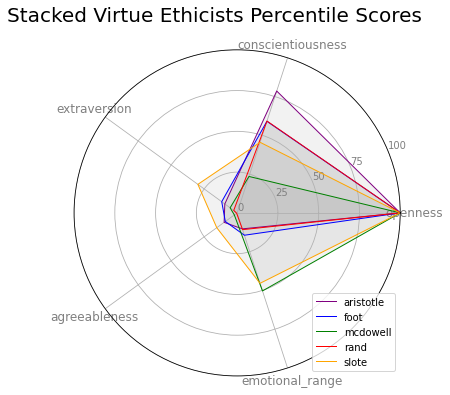

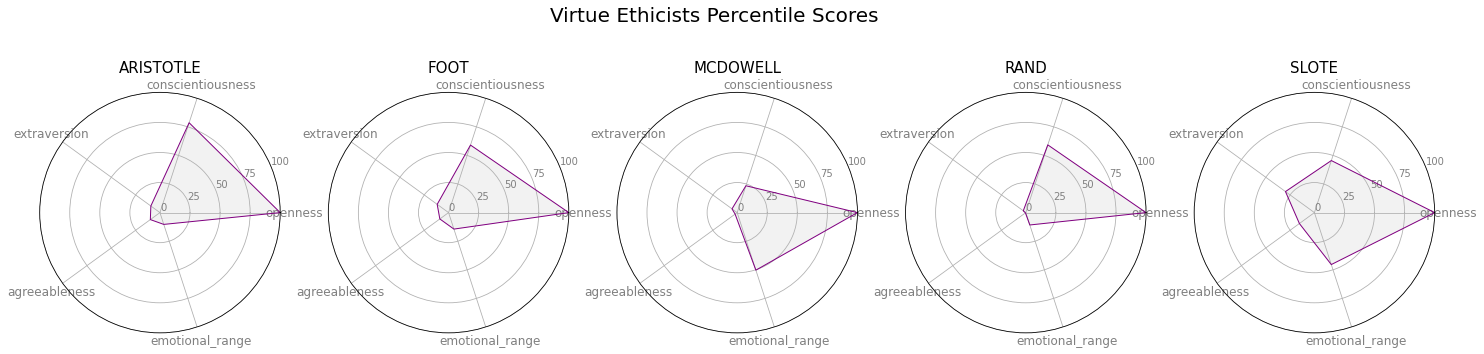

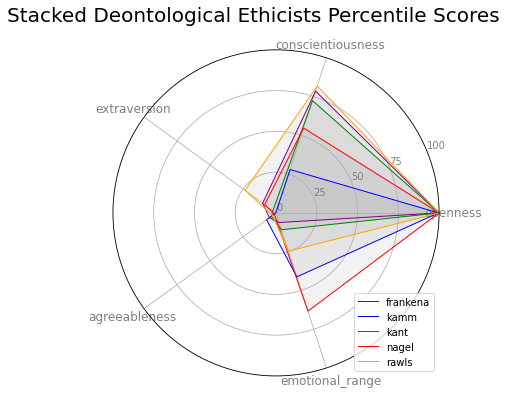

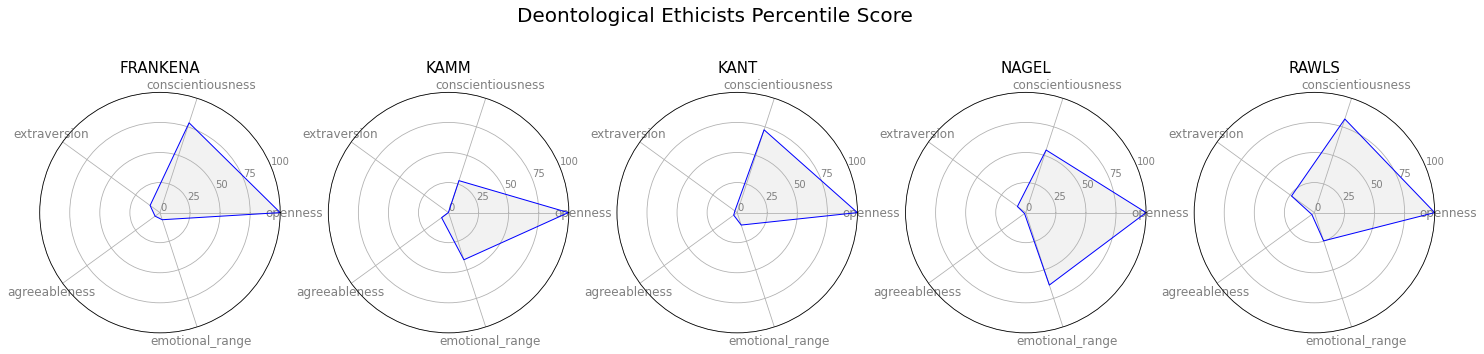

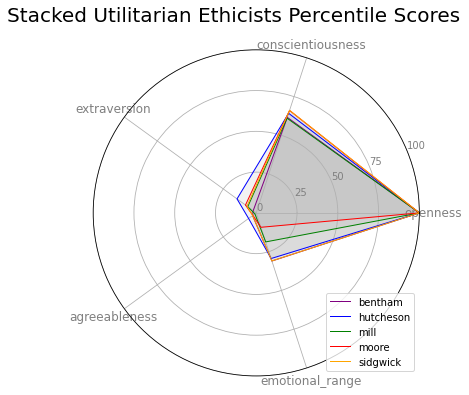

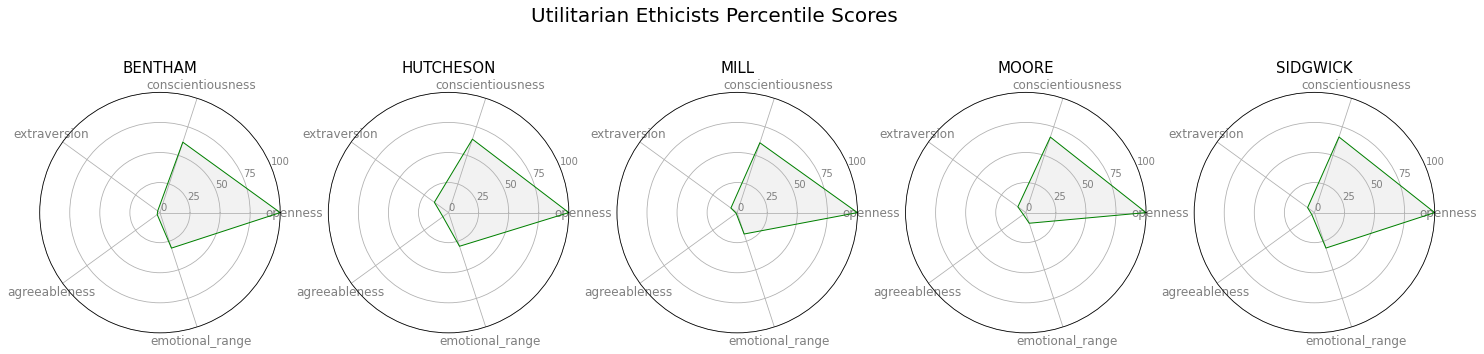

In [167]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def plot_radars(df, names, colors, index=1, shape=(1,1), raw=False, title=False, legend=False):
    labels = ['openness', 'conscientiousness', 'extraversion',
              'agreeableness', 'emotional_range']
    n = len(labels)
    legend_list = list()

    if raw:
        cols = ['raw_{}'.format(c) for c in labels]
    else:
        cols = ['pct_{}'.format(c) for c in labels]

    for name, color in zip(names, colors):
        row = df[df.philosopher == name]
        values = [row[c] * 100 for c in cols]
        values += values[:1]
        angles = [(i * 2 * np.pi) / n for i in range(n)]
        angles += angles[:1]

        axis = plt.subplot(*shape, 
                            index, projection='polar')
        plt.xticks(angles[:-1], labels, color='grey', size=12)
        ticks = range(0, 101, 25)
        plt.yticks(ticks, [str(t) for t in ticks], color="grey", size=10)
        plt.ylim(0, 100)

        axis.plot(angles, values, linewidth=1, linestyle='solid', color=color)
        axis.fill(angles, values, 'grey', alpha=0.1)
        if title:
            axis.set_title(name.upper(), size=15)
        if legend:
            legend_list.append(name)
    
    if legend:
        plt.legend(legend_list, loc='lower right')

    return axis


try:
    score_table
except NameError:
    score_table = pd.read_csv('data/scores/score_table.csv')

score_table.sort_values(by='philosopher', inplace=True)
virtue = score_table[score_table.ethics == 'virtue'].philosopher.to_list()
deontological = score_table[score_table.ethics == 'deontological'].philosopher.to_list()
utilitarian = score_table[score_table.ethics == 'utilitarian'].philosopher.to_list()

fig = plt.figure(figsize=(25, 6))
gs = fig.add_gridspec(1, 5, hspace=0, wspace=0)
fig.suptitle('Stacked Virtue Ethicists Percentile Scores', size=20)
colors = ['purple', 'blue', 'green', 'red', 'orange']
names = virtue
plot_radars(score_table, names, colors, legend=True)

fig = plt.figure(figsize=(25, 6))
gs = fig.add_gridspec(1, 1, hspace=0, wspace=0)
fig.suptitle('Virtue Ethicists Percentile Scores', size=20)
for e, name in enumerate(virtue):
    column = e + 1
    plot_radars(score_table, [name], colors=['purple'],
                index=column, shape=(1,5), title=True)


fig = plt.figure(figsize=(25, 6))
gs = fig.add_gridspec(1, 5, hspace=0, wspace=0)
fig.suptitle('Stacked Deontological Ethicists Percentile Scores', size=20)
colors = ['purple', 'blue', 'green', 'red', 'orange']
names = deontological
plot_radars(score_table, names, colors, legend=True)


fig = plt.figure(figsize=(25, 6))
gs = fig.add_gridspec(1, 5, hspace=0, wspace=0)
fig.suptitle('Deontological Ethicists Percentile Score', size=20)
for e, name in enumerate(deontological):
    column = e + 1
    plot_radars(score_table, [name], colors=['blue'],
                index=column, shape=(1,5), title=True)


fig = plt.figure(figsize=(25, 6))
gs = fig.add_gridspec(1, 5, hspace=0, wspace=0)
fig.suptitle('Stacked Utilitarian Ethicists Percentile Scores', size=20)
colors = ['purple', 'blue', 'green', 'red', 'orange']
names = utilitarian
plot_radars(score_table, names, colors, legend=True)

fig = plt.figure(figsize=(25, 6))
gs = fig.add_gridspec(1, 5, hspace=0, wspace=0)
fig.suptitle('Utilitarian Ethicists Percentile Scores', size=20)
for e, name in enumerate(utilitarian):
    column = e + 1
    plot_radars(score_table, [name], colors=['green'],
                index=column, shape=(1,5), title=True)


As we can see, the utilitarian philosophers have a similar calculated personality matrix, but the virtue and deontological philosophers seem to have greater within-group variation.

In [146]:
try:
    score_table
except NameError:
    score_table = pd.read_csv('data/scores/score_table.csv')

# Slicing pre-work
pct_scores = [c for c in score_table.columns if 'pct_' in c]
cols = ['ethics'] + pct_scores

# Caclulating the per-trait variability for both raw and percentile scores
pct_variability = score_table[cols].groupby('ethics').var()

var_by_ethics = pct_variability.mean(axis=1).sort_values()
var_by_ethics

ethics
utilitarian      0.002429
virtue           0.019203
deontological    0.022645
dtype: float64

Given the overall similarity, it appears as if we will not find any strong correlations between a philosopher's calculated personalities and their ethics.  Let's move away from visualizations and statistics, and formalize the question with hypotheses and statistical analyses.

_Hypothesis: A philospher's ethical position is correlated with their persistent personality traits as operationalized by their Big Five personality scores._
<br>
<br>
_Null Hypothesis: A philospher's ethical position is **not** correlated with their persistent personality traits as operationalized by their Big Five personality scores._
<br>
<br>
<br>

### Logistic Regressions

For each pair of ethical views (Virtue vs Deontological; Virtue vs Utilitarian; Utilitarian vs Deontological), we will perform a logistic regression to categorize the philosophers ethics based on their calculated personality score percentiles.

However, given the small sample size, we will not have enough degrees of freedom to use all five traits.  I have chosen to drop openness as an independent variable because of it's very low variance across all philosophers (<0.000001).


#### Virtue Ethics vs Deontological Ethics

In [147]:
import numpy as np
import pandas as pd
from patsy import dmatrices
import statsmodels.api as sm


try:
    score_table
except NameError:
    score_table = pd.read_csv('data/scores/score_table.csv')


ind_var_cols = [c for c in score_table.columns if 'pct_' in c and 'open' not in c]
dep_var_cols = ['ethics']
cols = ind_var_cols + dep_var_cols + ['philosopher']

model_data = score_table[score_table.ethics.isin(['virtue', 'deontological'])].loc[:, cols]
# Setting virtue as the "target"
model_data.loc[:, dep_var_cols] = np.where(model_data.ethics == 'virtue', 1, 0)

model_data.set_index('philosopher', inplace=True)

y, X = dmatrices('{} ~ {} + {} + {} + {}'.format(*dep_var_cols, *ind_var_cols),
                 data=model_data,
                 return_type='dataframe')

model = sm.Logit(y, X)
res = model.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.405888
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 ethics   No. Observations:                   10
Model:                          Logit   Df Residuals:                        5
Method:                           MLE   Df Model:                            4
Date:                Fri, 07 Aug 2020   Pseudo R-squ.:                  0.4144
Time:                        02:16:59   Log-Likelihood:                -4.0589
converged:                       True   LL-Null:                       -6.9315
Covariance Type:            nonrobust   LLR p-value:                    0.2190
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                19.9883     17.396      1.149      0.251     -14.108      54.

No personality trait has a significant relationship with endorsing a virtue ethics versus a deontological ethics (p-values all >0.05).

#### Virtue Ethics vs Utilitarian Ethics


In [148]:
import numpy as np
import pandas as pd
from patsy import dmatrices
import statsmodels.api as sm


try:
    score_table
except NameError:
    score_table = pd.read_csv('data/scores/score_table.csv')


ind_var_cols = [c for c in score_table.columns if 'pct_' in c and 'open' not in c]
dep_var_cols = ['ethics']
cols = ind_var_cols + dep_var_cols

model_data = score_table[score_table.ethics.isin(['virtue', 'utilitarian'])].loc[:, cols]
# Setting virtue as the "target"
model_data.loc[:, dep_var_cols] = np.where(model_data.ethics == 'virtue', 1, 0)


y, X = dmatrices('{} ~ 0 + {} + {} + {} + {}'.format(*dep_var_cols, *ind_var_cols),
                 data=model_data,
                 return_type='dataframe')

model = sm.Logit(y, X)
res = model.fit()
print(res.summary())


Optimization terminated successfully.
         Current function value: 0.443052
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 ethics   No. Observations:                   10
Model:                          Logit   Df Residuals:                        6
Method:                           MLE   Df Model:                            3
Date:                Fri, 07 Aug 2020   Pseudo R-squ.:                  0.3608
Time:                        02:17:07   Log-Likelihood:                -4.4305
converged:                       True   LL-Null:                       -6.9315
Covariance Type:            nonrobust   LLR p-value:                    0.1717
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
pct_conscientiousness    -3.0177      2.739     -1.102      0.271      -8.385       2.

No personality trait has a significant relationship with endorsing a virtue ethics versus a utilitarian ethics (p-values all >0.05).

#### Deontological Ethics vs Utilitarian Ethics


In [149]:
import numpy as np
import pandas as pd
from patsy import dmatrices
import statsmodels.api as sm


try:
    score_table
except NameError:
    score_table = pd.read_csv('data/scores/score_table.csv')


ind_var_cols = [c for c in score_table.columns if 'pct_' in c and 'open' not in c]
dep_var_cols = ['ethics']
cols = ind_var_cols + dep_var_cols

model_data = score_table[score_table.ethics.isin(['deontological', 'utilitarian'])].loc[:, cols]
# Setting deontological as the "target"
model_data.loc[:, dep_var_cols] = np.where(model_data.ethics == 'deontological', 1, 0)


y, X = dmatrices('{} ~ {} + {} + {} + {}'.format(*dep_var_cols, *ind_var_cols),
                 data=model_data,
                 return_type='dataframe')

model = sm.Logit(y, X)
res = model.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.598269
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 ethics   No. Observations:                   10
Model:                          Logit   Df Residuals:                        5
Method:                           MLE   Df Model:                            4
Date:                Fri, 07 Aug 2020   Pseudo R-squ.:                  0.1369
Time:                        02:17:55   Log-Likelihood:                -5.9827
converged:                       True   LL-Null:                       -6.9315
Covariance Type:            nonrobust   LLR p-value:                    0.7546
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -9.4177     10.271     -0.917      0.359     -29.549      10.

No personality trait has a significant relationship with endorsing a deontological ethics versus a utilitarian ethics (p-values all >0.05).
<br>
<br>
<br>

### Multinomial Logistic Regressions


In [150]:
import statsmodels.api as sm
from patsy import dmatrices


ind_var_cols = [c for c in score_table.columns if 'pct_' in c and 'open' not in c]
dep_var_cols = ['ethics']
cols = ind_var_cols + dep_var_cols

model_data = score_table.loc[:, cols]
# Setting the categories

y, X = dmatrices('{} ~ {} + {} + {} + {}'.format(*dep_var_cols, *ind_var_cols),
                 data=model_data,
                 return_type='dataframe')

model = sm.MNLogit(y, X)
res = model.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.816210
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                   15
Model:                        MNLogit   Df Residuals:                        5
Method:                           MLE   Df Model:                            8
Date:                Fri, 07 Aug 2020   Pseudo R-squ.:                  0.2571
Time:                        02:18:31   Log-Likelihood:                -12.243
converged:                       True   LL-Null:                       -16.479
Covariance Type:            nonrobust   LLR p-value:                    0.3888
y=ethics[utilitarian]       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.5814      5.443      0.474      0.635      -8.086      13.

No personality trait has a significant relationship with endorsing any particular kind of ethics (p-values all >0.05).
<br>
<br>
<br>


### K-means Analysis

I wanted to see how an unsupervised categorization algorithm like K-means would view the philosophers.  Given the difficulty in presenting 5-dimensional data, I chose to plot the philosophers on the two dimensions where there was the greatest variability: conscientiousness and emotional range.  And given that we have three natural groups, I will start with three centroids.


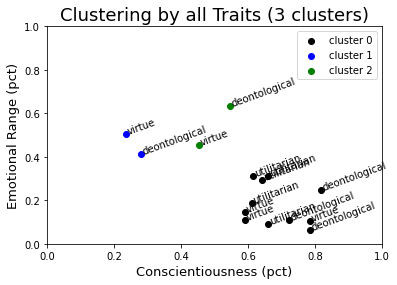

In [151]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans


try:
    score_table
except NameError:
    score_table = pd.read_csv('data/scores/score_table.csv')


labels = ['ethics', 'philosopher']
cluster_cols = [c for c in score_table.columns if 'pct_' in c]

model_data = score_table.loc[:, labels + cluster_cols]
model_data.set_index(labels, inplace=True)


def visualize_clusters(df, num_clusters):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    kmeans = KMeans(num_clusters).fit(model_data)
    model_data['cluster'] = kmeans.labels_

    for n in range(num_clusters):
        cluster_df = df[df.cluster == n]
        x = cluster_df.pct_conscientiousness
        y = cluster_df.pct_emotional_range
        plt.scatter(x, y, c=colors[n-1])
        for i, txt in enumerate(cluster_df.index):
            plt.annotate(txt[0], (x[i], y[i]), rotation=20)

        plt.xlabel('Conscientiousness (pct)', fontsize=13)
        plt.ylabel('Emotional Range (pct)', fontsize=13)
        plt.title('Clustering by all Traits ({} clusters)'.format(num_clusters),
                  fontsize=18)
        plt.legend(['cluster {}'.format(i) for i in range(num_clusters)])
        plt.xlim((0,1))
        plt.ylim((0,1))

    plt.show()

visualize_clusters(model_data, 3)


The K-means analysis with the same number of clusters as we had groups was not fruitful.  And by that I mean the visualization itself does not give us a great insight into how similar (close) or different (far) these philosophers are from each other in the five-dimensions of personality scores.

I believe a better visualization will be a heatmap of their 5-D euclidean distances. However, for posterity's sake, I will perform an elbow test of the K-means analysis and run one more visualization of the resulting centroid number (if it's not 3).

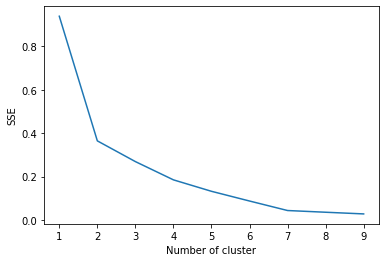

In [152]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans


try:
    score_table
except NameError:
    score_table = pd.read_csv('data/scores/score_table.csv')


labels = ['ethics', 'philosopher']
cluster_cols = [c for c in score_table.columns if 'pct_' in c]

model_data = score_table.loc[:, labels + cluster_cols]
model_data.set_index(labels, inplace=True)

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k).fit(model_data)
    model_data["cluster"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()


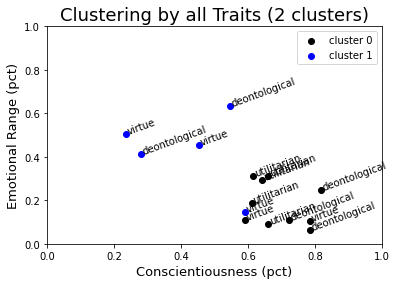

In [153]:
visualize_clusters(model_data, 2)

As expected that did not clarify much....
<br>
<br>

### Distance Heatmaps (Bonus Visualizations)

As mentioned above, the K-means analysis did not provide a good sense of how similar or different the groups of philosophers are.  To visualize this facet of the data, I will calculate the distances for each pair of philosophers, group them by ethics, and then make a 3x3 heatmap of the within and between group distances. 

Text(0.5, 1.0, 'Distances Between and Within Ethics Groups')

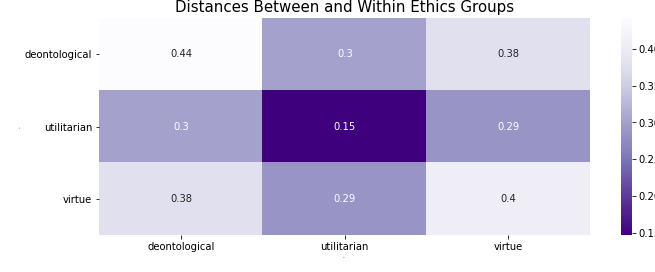

In [166]:
from collections import namedtuple
from functools import partial
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb


try:
    score_table
except NameError:
    score_table = pd.read_csv('data/scores/score_table.csv')


labels = ['ethics', 'philosopher']
dim_cols = [c for c in score_table.columns if 'pct_' in c]

start_data = score_table.loc[:, labels + dim_cols]
# distance_data.set_index(labels, inplace=True)

DataRow = namedtuple('DataRow', ['ethics', 'philosopher',
                                 'comp_ethics', 'comp_philosopher',
                                 'distance'])

distance_data = list()
for ind, row in start_data.iterrows():
    distance_list = [DataRow(ethics=row.ethics,
                             philosopher=row.philosopher,
                             comp_ethics=comp_row.ethics,
                             comp_philosopher=comp_row.philosopher,
                             distance=np.linalg.norm(row[dim_cols] - comp_row[dim_cols]))
                     for ind, comp_row in start_data.iterrows()]
    
    distance_data.extend(distance_list)

distance_df = pd.DataFrame(distance_data, columns=DataRow._fields)
# removing comparisons between the same philosophers
distance_df = distance_df[distance_df.philosopher != distance_df.comp_philosopher]

within_and_between_distances = distance_df.groupby(['ethics', 'comp_ethics']).distance.mean()

within_and_between_df = within_and_between_distances.unstack()


fig, ax = plt.subplots(figsize=(11,4))
ax = sb.heatmap(within_and_between_df, annot=True, cmap='Purples_r')
ax.set_xlabel('Ethics', size=0)
ax.set_ylabel('Ethics', size=0)
ax.set_yticklabels(within_and_between_df.index, rotation=0)
ax.set_title('Distances Between and Within Ethics Groups', size=15)

That is a much better picture of how similar or different the different categories of philosophers are (with respect to their calculated personality scores).

It's now clear that results align with what we saw with the radar plots: the utilitarians are more similar to each other than to the other groups.  And a new finding we get from this visualization, which was not immediately obvious from the radar charts or our analyses: both the deontologists and virtuists are more similar to other groups than they are to themselves.

And now, for fun, here is the pairwise distance matrix for all philosophers.


Text(0.5, 1.0, 'Distances Between Philosopers')

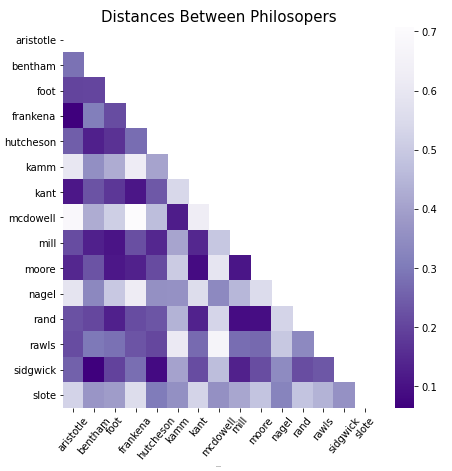

In [129]:
# import pkg_resources

from collections import namedtuple
from functools import partial
from matplotlib.lines import Line2D
# pkg_resources.require("Matplotlib==3.1.0")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb


try:
    score_table
except NameError:
    score_table = pd.read_csv('data/scores/score_table.csv')


labels = ['ethics', 'philosopher']
dim_cols = [c for c in score_table.columns if 'pct_' in c]

start_data = score_table.loc[:, labels + dim_cols]
# distance_data.set_index(labels, inplace=True)

DataRow = namedtuple('DataRow', ['ethics', 'philosopher',
                                 'comp_ethics', 'comp_philosopher',
                                 'distance'])

distance_data = list()
for ind, row in start_data.iterrows():
    distance_list = [DataRow(ethics=row.ethics,
                             philosopher=row.philosopher,
                             comp_ethics=comp_row.ethics,
                             comp_philosopher=comp_row.philosopher,
                             distance=np.linalg.norm(row[dim_cols] - comp_row[dim_cols]))
                     for ind, comp_row in start_data.iterrows()]
    
    distance_data.extend(distance_list)


distance_pivot = distance_df.pivot(index='philosopher',
                                   columns='comp_philosopher',
                                   values='distance')



mask = np.zeros_like(distance_pivot, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


fig, ax = plt.subplots(figsize=(7,7))
ax = sb.heatmap(distance_pivot, annot=False, cmap='Purples_r', mask=mask)
ax.set_xlabel('Philosopher', size=0)
ax.set_ylabel('Philosopher', size=0)
ax.set_xticklabels(distance_pivot.index, rotation=50)
ax.set_title('Distances Between Philosopers', size=15)
# plt.xlim([0,15])
# plt.ylim([0,15])

## Conclusion

We found no evidence that a philosopher's ethical beliefs are informed or correlated with their personality traits (as measured by their Big Five personality score).

One clear trend we found is that utilitarians are more similar to themselves, whereas deontologists and virtuists have less group similarities.

However, these findings are tentative at best. One reason to be skeptical of these results is simply that I did not have the ability to (easily) collect enough data. Another reason to be skeptical is the fact that I used philosophical texts, as opposed to more informal writing you'd find in letters or diaries.  While I'm deeply interested in pursuing this hypothesis further, I do not think it makes sense to do so until I gain access to a suitable web portal with easy access to philosophic texts &mdash; or better yet &mdash; the letters and diaries of philosophers.

